In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import ResNet50
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Path of dataset
TRAIN_PATH = '/content/drive/MyDrive/Dataset/BanglaCurrency/Training'

In [3]:
takas = os.listdir(TRAIN_PATH)
takas = takas[0:]
print(takas)

['10', '1', '100', '500', '1000', '20', '5', '200', '2', '50']


In [4]:
# Data Preprocessing
image_size = (250, 120)
batch_size = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1697 files belonging to 10 classes.
Using 1358 files for training.
Found 1697 files belonging to 10 classes.
Using 339 files for validation.


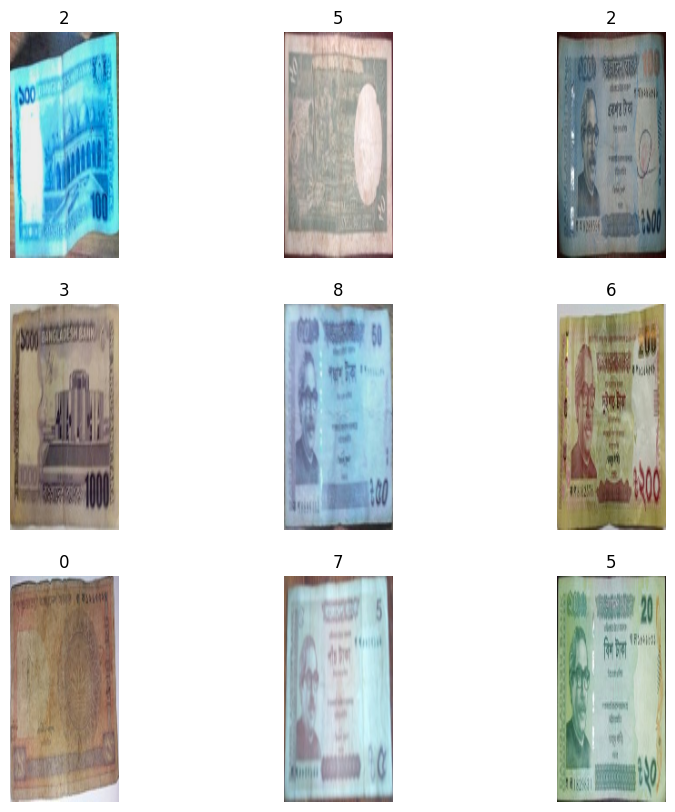

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

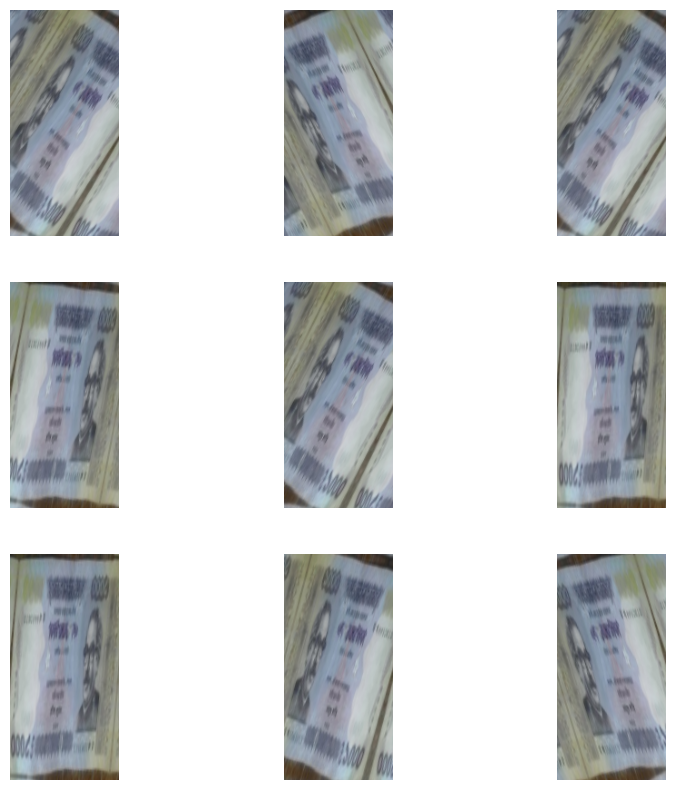

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [10]:
# Load ResNet50 Model
IMAGE_SIZE = [250, 120]
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in resnet.layers:
    layer.trainable = False

x = Flatten()(resnet.output)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
# Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 250, 120, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 256, 126, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 125, 60, 64)    │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 125, 60, 64)    │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 125, 60, 64)    │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 127, 62, 64)    │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 63, 30, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 63, 30, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 63, 30, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 63, 30, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 63, 30, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 63, 30, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 63, 30, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 63, 30, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 63, 30, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,243,082 (92.48 MB)

 Trainable params: 655,370 (2.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
# Train Model
epochs = 10
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 276s 24s/step - accuracy: 0.2875 - loss: 7.7643 - val_accuracy: 0.6903 - val_loss: 3.3080
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 208s 14s/step - accuracy: 0.7587 - loss: 1.4923 - val_accuracy: 0.7906 - val_loss: 1.3378
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 205s 15s/step - accuracy: 0.9107 - loss: 0.4202 - val_accuracy: 0.8437 - val_loss: 0.9225
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 140s 13s/step - accuracy: 0.9491 - loss: 0.2489 - val_accuracy: 0.9263 - val_loss: 0.4331
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.9795 - loss: 0.0777 - val_accuracy: 0.9086 - val_loss: 0.5762
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 161s 15s/step - accuracy: 0.9772 - loss: 0.0917 - val_accuracy: 0.9469 - val_loss: 0.3156
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 156s 14s/step - accuracy: 0.9849 - loss: 0.0537 - val_accuracy: 0.9558 - val_loss: 0.3258
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 154s 14s/step - accuracy: 0.9834 - loss: 0.0622 - val_accuracy: 0.

In [13]:
# Save Model
model.save("/content/drive/MyDrive/dataset/saved_model/BanglaCurrencyRecognitionModel(resNet).h5")

In [14]:
# Evaluate Model
y_true = []
y_pred = []
for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


In [15]:
# Performance Metrics
print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       1.00      0.95      0.98        42
           2       0.79      1.00      0.88        53
           3       0.97      0.97      0.97        35
           4       1.00      0.97      0.99        37
           5       0.94      0.94      0.94        32
           6       1.00      1.00      1.00        13
           7       1.00      0.91      0.95        43
           8       0.92      0.97      0.95        37
           9       0.96      0.71      0.81        31

    accuracy                           0.94       339
   macro avg       0.96      0.94      0.94       339
weighted avg       0.95      0.94      0.94       339

Confusion Matrix:
[[15  0  0  0  0  1  0  0  0  0]
 [ 0 40  1  0  0  0  0  0  1  0]
 [ 0  0 53  0  0  0  0  0  0  0]
 [ 0  0  1 34  0  0  0  0  0  0]
 [ 0  0  1  0 36  0  0  0  0  0]
 [ 0  0  2  0  0 30  0  0  0  0]
 [

In [17]:
# Testing with a Sample Image
currency = ["1", "10", "100", "1000", "2", "20", "200", "5", "50", "500"]
img_path = "/content/drive/MyDrive/Dataset/BanglaCurrency/Testing/0.jpg"
img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print("Predicted Currency:", currency[predictions.argmax()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Predicted Currency: 100


In [20]:
# Audio Feedback
from IPython.display import Audio
audio_files = {
    "1": "one.mp3", "2": "two.mp3", "5": "five.mp3", "10": "ten.mp3",
    "20": "twenty.mp3", "50": "fifty.mp3", "100": "onehundred.mp3",
    "200": "twohundred.mp3", "500": "fivehundred.mp3", "1000": "thousand.mp3"
}
if currency[predictions.argmax()] in audio_files:
    wn = Audio(f'/content/drive/MyDrive/Dataset/BanglaCurrency/Voice/{audio_files[currency[predictions.argmax()]]}', autoplay=True)
    display(wn)
else:
    print("Something went wrong!")